# AHRS with MPU9250

This notebook demonstrates the use of MPU9250 as an AHRS (Attitude Heading Reference System) from aquisitions obtained with an Arduino.
Each acquisition is a CSV containing timestamped raw samples from the 3 sensors (accelerometer,gyroscope and magnetometer) obtained while the device was performing rotations through different axis: pitching down and up, rolling left and right, doing a 360° yaw, etc.

## CSV input format

Each CSV contains several samples wit the following structure:

$$
t_s,a_x,a_y,a_z,g_x,g_y,g_z,b_x,b_y,b_z
$$

where:

$$
t_s: \text{timestamp in milliseconds since boot} \\
a_x: \text{x-axis acceleration}, LSB= 2mG \\
a_y: \text{y-axis acceleration}, LSB= 2mG \\
a_z: \text{z-axis acceleration}, LSB= 2mG \\
g_x: \text{angular velocity in x axis}, FS=250dps \\
g_y: \text{angular velocity in y axis}, FS=250dps \\
g_z: \text{angular velocity in z axis}, FS=250dps \\
b_x: \text{magnetic flux density in x axis}, FS=4912 \mu T \\
b_y: \text{magnetic flux density in y axis}, FS=4912\mu T \\
b_z: \text{magnetic flux density in z axis}, FS=4912\mu T 
$$

Notes:
- All values are signed 16bit integer.
- LSB = Less Significant Bit
- FS = Full Scale (32760).

Angle measurements are obtained from two sources:
- Magnetometer and accelerometer (g-force and magnetic vector axis decomposition)
- Gyroscope (integration)

## Formulae

Roll and pitch are obtained from accelerometer with the following equations:

$$
roll:  \theta = atan(\frac{-a_x}{g}) \\
pitch: \phi = atan(\frac{a_y}{a_z}) \\
$$

Yaw is calculated from magnetometer:

$$
yaw:   \psi = atan(\frac{ cos\theta ( b_z sin\phi- b_y cos\phi )}{ b_x + B sin I sin\theta } + D
$$

where:

$$
B: \text{magnitude of the magnetic field} [\mu T] \\
I: \text{is the inclination of the magnetic field vector} \\
D: \text{is the declination of the magnetic field vector} \\
$$

Angles from gyroscope integration:

$$
roll:  \theta = \int_{t_0}^{t}{g_x dt} \\
pitch:  \phi = \int_{t_0}^{t}{g_y dt} \\
yaw:  \psi = \int_{t_0}^{t}{g_z dt} \\
$$

## References

- [QUT Robot Academy - Measuring Motion](https://robotacademy.net.au/masterclass/measuring-motion/)
- [NOAA Magnetic Field Calculator](https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfgrid)
- [Sensor Fusion: Part 1](http://www.telesens.co/2017/04/27/sensor-fusion-part-1/)
- [Sensor Fusion: Part 2](http://www.telesens.co/2017/04/30/sensor-fusion-part-2-combining-gyro-accel-data/)
- [Sensor Fusion: Part 3](http://www.telesens.co/2017/05/02/sensor-fusion-part-3-implementation-of-gyro-accel-sensor-fusion/)
- [Sensor Fusion: Part 4](http://www.telesens.co/2017/05/07/sensor-fusion-part-4/)

## Procedure

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Functions

In [2]:
G_EARTH = 9806.65 # -9.80665 m/s2

def load_and_preprocess_file(filename, convert_measurements=True):    
    df = pd.read_csv(filename)    
    # Get rid of last column with NaNs.
    df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
    # Remove invalid magnetometer readings
    df = df[df["mag_valid"]==1]
    # Drop NaNs
    df.dropna()
    # Finally, drop column with magnetometer valid flag.
    df = df.drop(columns=['mag_valid'])
        
    if convert_measurements == True:            
        df['ax'] = df['ax'] * (2.0*G_EARTH)/ 32768.0
        df['ay'] = df['ay'] * (2.0*G_EARTH)/ 32768.0
        df['az'] = df['az'] * (2.0*G_EARTH)/ 32768.0
        df['gx'] = df['gx'] / 131.0 * 0.0174533
        df['gy'] = df['gy'] / 131.0 * 0.0174533
        df['gz'] = df['gz'] / 131.0 * 0.0174533
        df['mx'] = df['mx'] * (4912/32760.0)
        df['my'] = df['my'] * (4912/32760.0)
        df['mz'] = df['mz'] * (4912/32760.0)
    return df

In [3]:
def deg2rad(x):
    return x*0.0174533

def rad2deg(x):
    return x*57.2958

### Gyro

In [4]:
def integrate_gyro(g,ts):
    t0 = ts[0]
    result = np.zeros(g.shape[0])
    for i in range(1,g.shape[0]):
        dt=(ts[i]-t0)/1000.0
        result[i]=result[i-1]+g[i]*dt
        t0 = ts[i]
    return result

def process_and_plot_gyro(df):
    ts = df.values[:,0]
    gx = df.values[:,4] 
    gy = df.values[:,5] 
    gz = df.values[:,6] 
    t = np.arange(gx.shape[0])    
    gxi = integrate_gyro(gx,ts)
    gyi = integrate_gyro(gy,ts)
    gzi = integrate_gyro(gz,ts)
    fig = plt.figure(figsize=(20, 14))
    plt.plot(t,rad2deg(gxi),t,rad2deg(gyi),t,rad2deg(gzi))
    plt.title("Angles from gyroscope")
    plt.grid(which="Both")
    plt.legend(["x","y","z"])
    plt.ylabel("Degrees")
    plt.xlabel("Time")
    return gxi,gyi,gzi

def process_pitch_roll(df):
    ax = df.values[:,1] 
    ay = df.values[:,2] 
    az = df.values[:,3] 
    ax=np.clip(ax,-G_EARTH,G_EARTH)
    ay=np.clip(ay,-G_EARTH,G_EARTH)
    az=np.clip(az,-G_EARTH,G_EARTH)
    pitch = np.arcsin(-ax/-G_EARTH)
    roll = np.arctan2(ay,az)
    return pitch, roll

def plot_gyro_vs_acc(gyro,acc):
    fig = plt.figure(figsize=(20, 14))
    t=np.arange(gyro.shape[0])
    plt.plot(t,gyro,t,acc)
    plt.grid(which="Both")
    plt.title("Pitch and Roll - Gyroscope vs Accelerometer")
    plt.legend(["gyroscope","accelerometer"])
    plt.xlabel("Samples")
    plt.ylabel("Rotation(degrees)")

### Exploratory Data Analysis

In [5]:
df=load_and_preprocess_file("../data/magcal.csv",convert_measurements=True)
df.head()

,t,ax,ay,az,gx,gy,gz,mx,my,mz
0,14541061,-478.840332,92.775314,9701.305127,-0.009326,-0.002931,0.013989,2.399023,233.604884,40.783394
1,5017,-481.833084,104.147772,9700.706577,-0.010392,-0.003064,0.014123,3.448596,234.354579,40.633455
2,5027,-483.030185,110.731827,9700.108026,-0.010259,-0.002798,0.013856,4.798046,232.705250,41.083272
3,5037,-485.424387,114.323129,9703.699329,-0.010525,-0.002531,0.013856,3.298657,231.805617,41.683028
4,5047,-490.212790,108.337625,9707.290631,-0.009992,-0.003331,0.013989,3.898413,232.705250,40.483516


### Plots of pose estimation

#### Pitch up, then down

In [6]:
df=load_and_preprocess_file("../data/pitch-up-then-down.csv",convert_measurements=True)

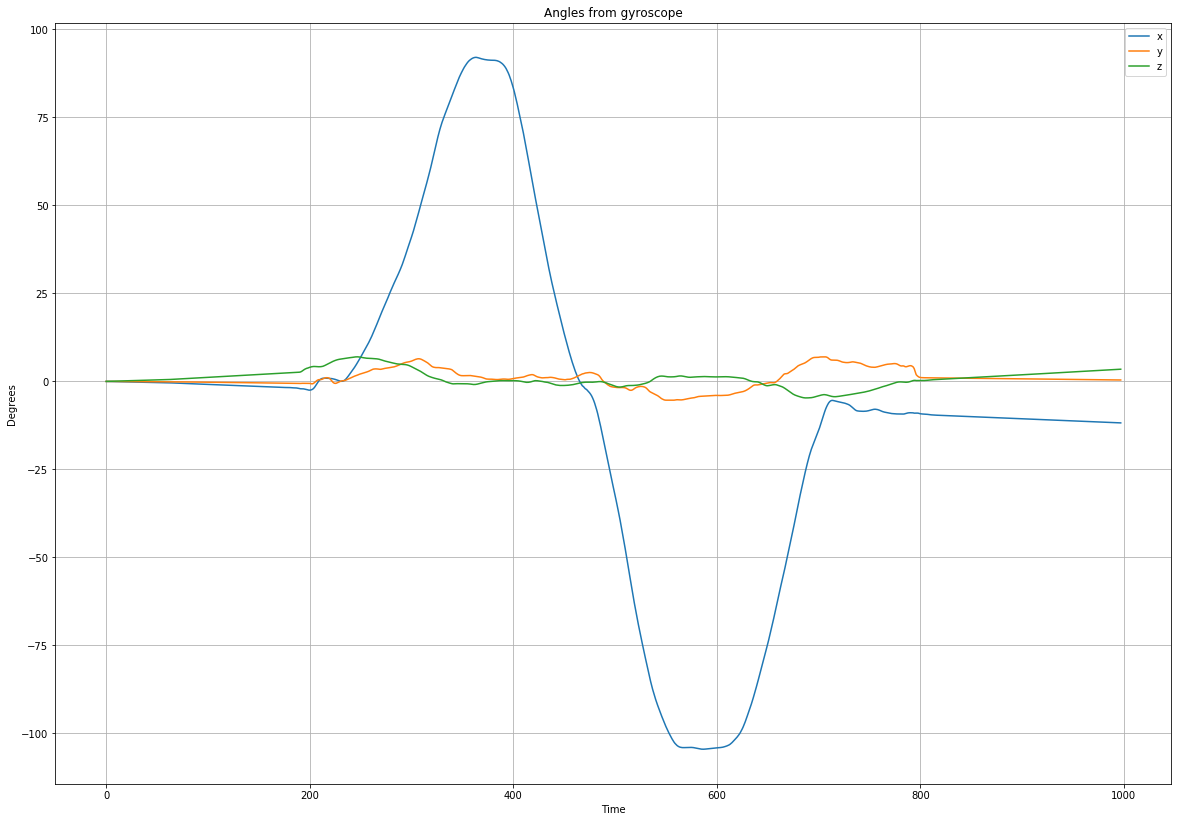

In [7]:
gxi,gyi,gzi = process_and_plot_gyro(df)

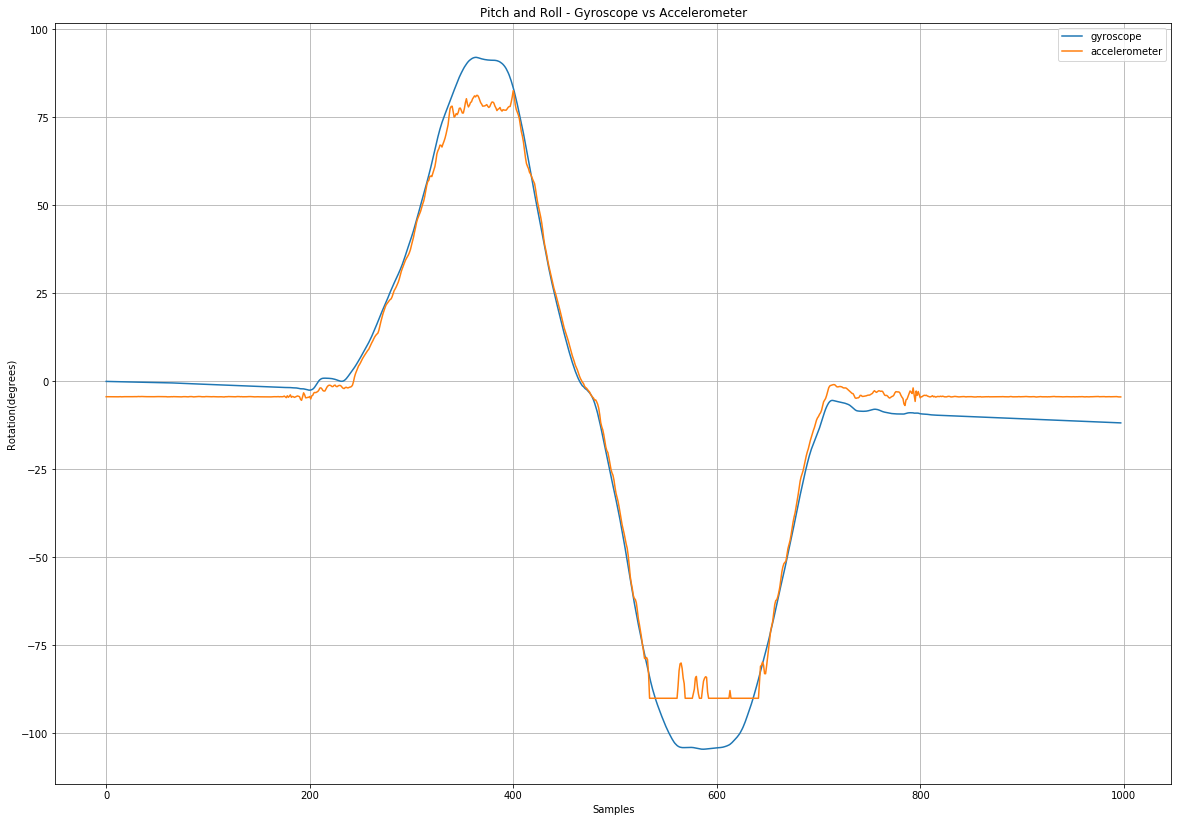

In [8]:
pitch,roll=process_pitch_roll(df)
plot_gyro_vs_acc( rad2deg(gxi),rad2deg(pitch))

Observation: the clipping of the angles calculated from accelerometer is due to the additional acceleration of the device not being at rest.

####  roll-left-then-right

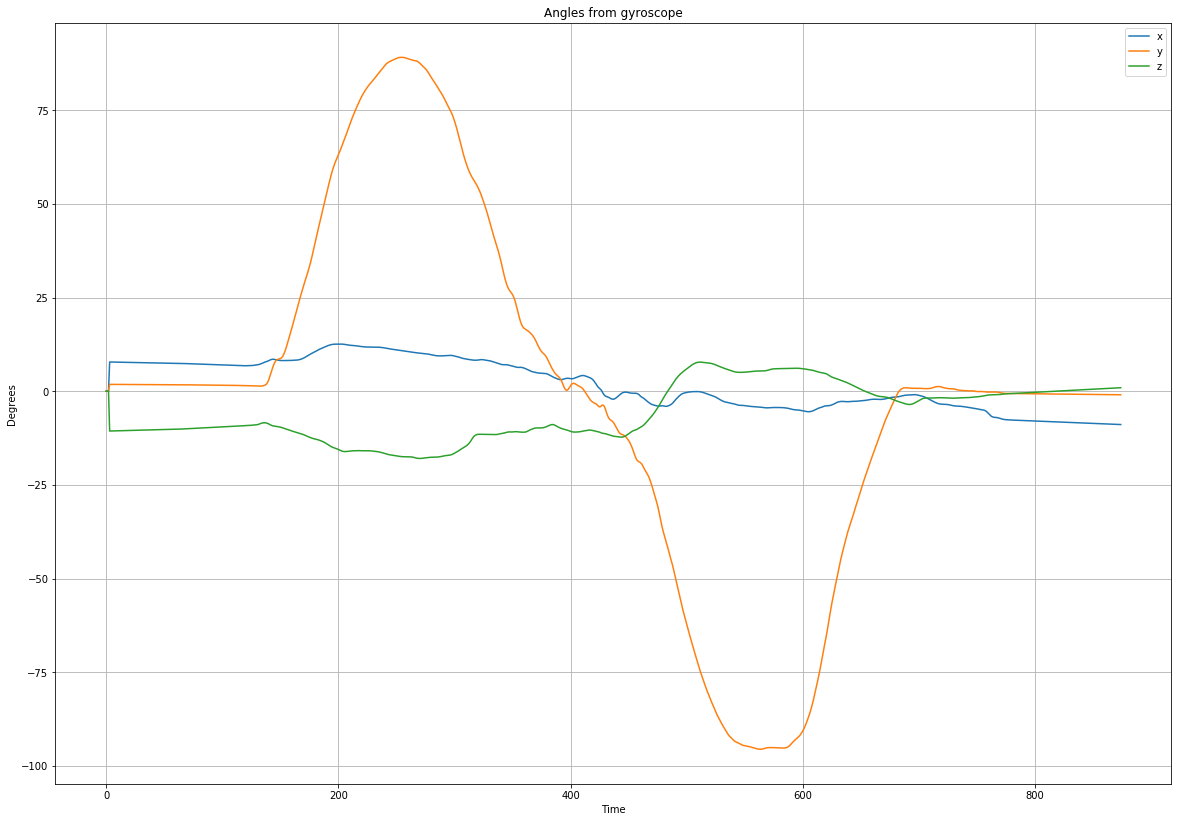

In [9]:
df=load_and_preprocess_file("../data/roll-left-then-right.csv",convert_measurements=True)
gxi,gyi,gzi = process_and_plot_gyro(df)

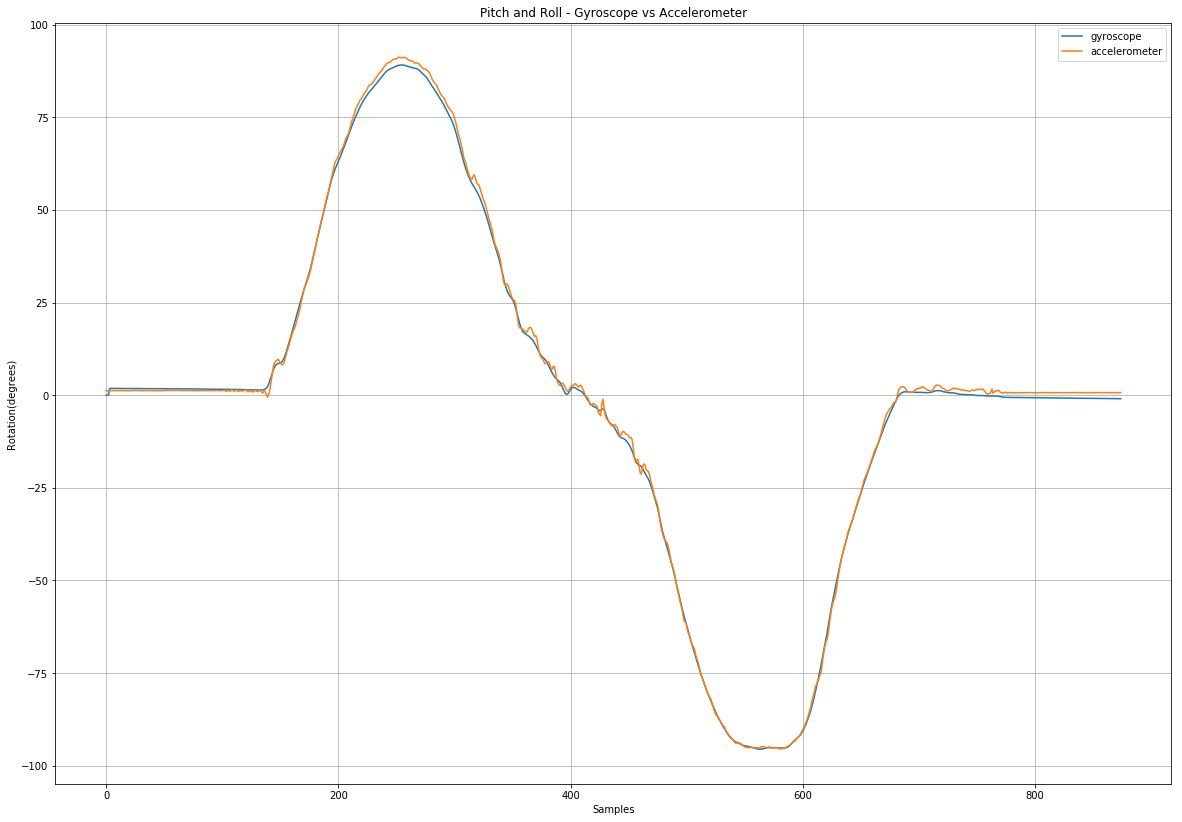

In [10]:
pitch,roll=process_pitch_roll(df)
plot_gyro_vs_acc(rad2deg(gyi),rad2deg(roll))

### Magnetometer calibration

In [11]:
df=load_and_preprocess_file("../data/magcal.csv",convert_measurements=True)

Text(0.5,1,'Magnetometer without calibration [mG]')

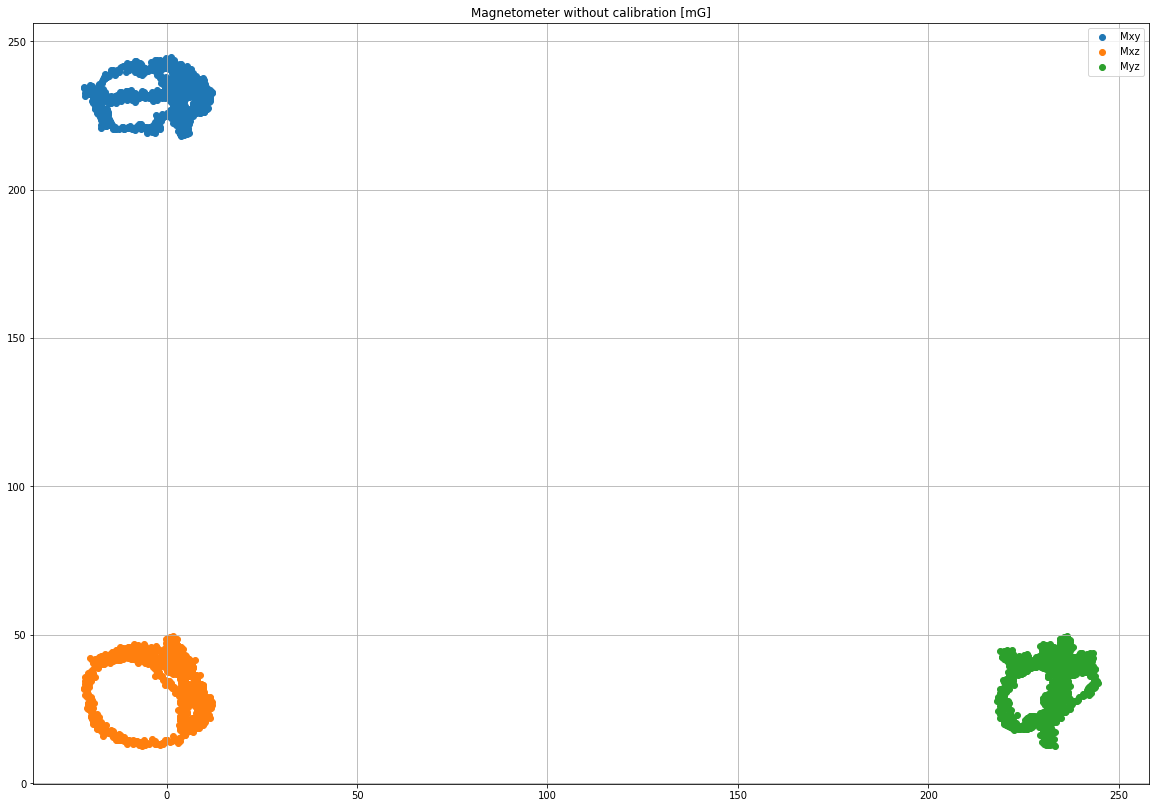

In [12]:
mx = df.values[:,7] 
my = df.values[:,8]
mz = df.values[:,9]

fig = plt.figure(figsize=(20, 14))
plt.grid(which='Both')
plt.scatter(mx,my)
plt.scatter(mx,mz)
plt.scatter(my,mz)
plt.legend(["Mxy","Mxz","Myz"])
plt.title("Magnetometer without calibration [mG]")

Hard Iron correction

In [13]:
def calculate_mag_correction(df):
    mx = df.values[:,7] 
    my = df.values[:,8]
    mz = df.values[:,9]
    corr_x = (mx.min() + mx.max())/2
    corr_y = (my.min() + my.max())/2
    corr_z = (mz.min() + mz.max())/2
    return corr_x,corr_y,corr_z

Correction -4.798046398046397 231.2808302808303 30.96239316239316


Text(0.5,1,'Calibrated magnetometer [$\\mu T$]')

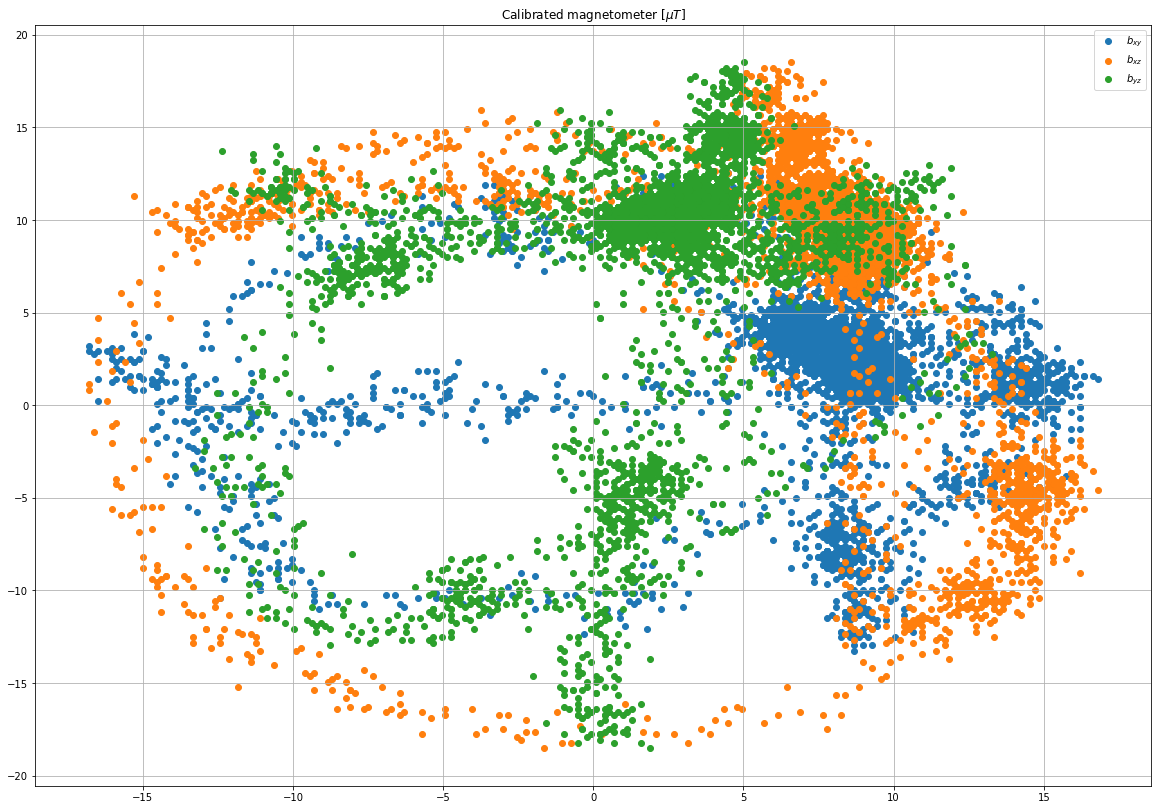

In [14]:
corr_x,corr_y,corr_z = calculate_mag_correction(df)
print("Correction",corr_x,corr_y,corr_z)
mx_corr = (mx - corr_x)*1.0
my_corr = (my - corr_y)*1.0
mz_corr = (mz - corr_z)*1.0
fig = plt.figure(figsize=(20, 14))
plt.grid(which='Both')
plt.scatter(mx_corr,my_corr)
plt.scatter(mx_corr,mz_corr)
plt.scatter(my_corr,mz_corr)
plt.legend(["$b_{xy}$","$b_{xz}$","$b_{yz}$"])
plt.title("Calibrated magnetometer [$\mu T$]")

### Yaw calculation

Constants (source: https://www.magnetic-declination.com/)
~~~
San Carlos de Bariloche Rio Negro
Latitude: 41° 8' 44.1" S
Longitude: 71° 18' 29.6" W
BARILOCHE
Magnetic Declination: +6° 26'
Declination is POSITIVE (EAST)
Inclination: 41° 43'
Magnetic field strength: 25640.6 nT
~~~


In [15]:
B = 25640/1000 # uT
I = 41 * 0.0174533

In [16]:
def process_yaw(df, pitch, roll):
    corr_x,corr_y,corr_z = calculate_mag_correction(df)
    mx = df.values[:,7] - corr_x
    my = df.values[:,8] - corr_y
    mz = df.values[:,9] - corr_z    

    yaw = np.arctan2(
        np.cos(pitch) * mz*np.sin(roll)-my*np.cos(roll),
        mx + B * np.sin(I)*np.sin(roll)
    )
    return yaw

In [17]:
df=load_and_preprocess_file("../data/yaw-360.csv",convert_measurements=True)

Plot raw magnetometer values.

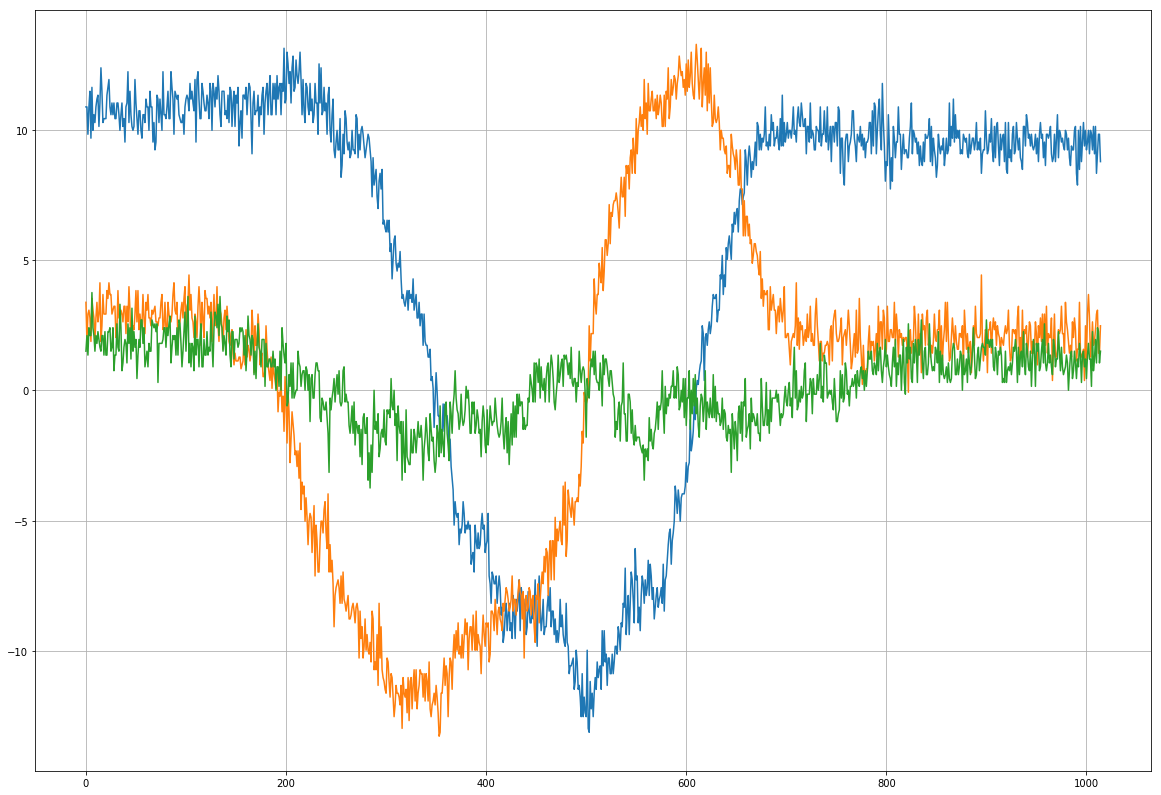

In [18]:
corr_x,corr_y,corr_z = calculate_mag_correction(df)
mx = df.values[:,7] - corr_x
my = df.values[:,8] - corr_y
mz = df.values[:,9] - corr_z  

t = np.arange(mx.shape[0])
fig = plt.figure(figsize=(20, 14))
plt.plot(t,mx,t,my,t,mz)
plt.grid(which='Both')

Plot yaw in captures

In [19]:
def process_and_plot_yaw(df):
    pitch,roll=process_pitch_roll(df)
    yaw = process_yaw(df, pitch, roll)
    t = np.arange(df.shape[0])
    fig = plt.figure(figsize=(20, 14))
    plt.plot(t,rad2deg(yaw))
    plt.grid(which='Both')
    plt.title("Yaw rotation from magnetometer and accelerometer")
    plt.xlabel("Samples")
    plt.ylabel("Degrees")

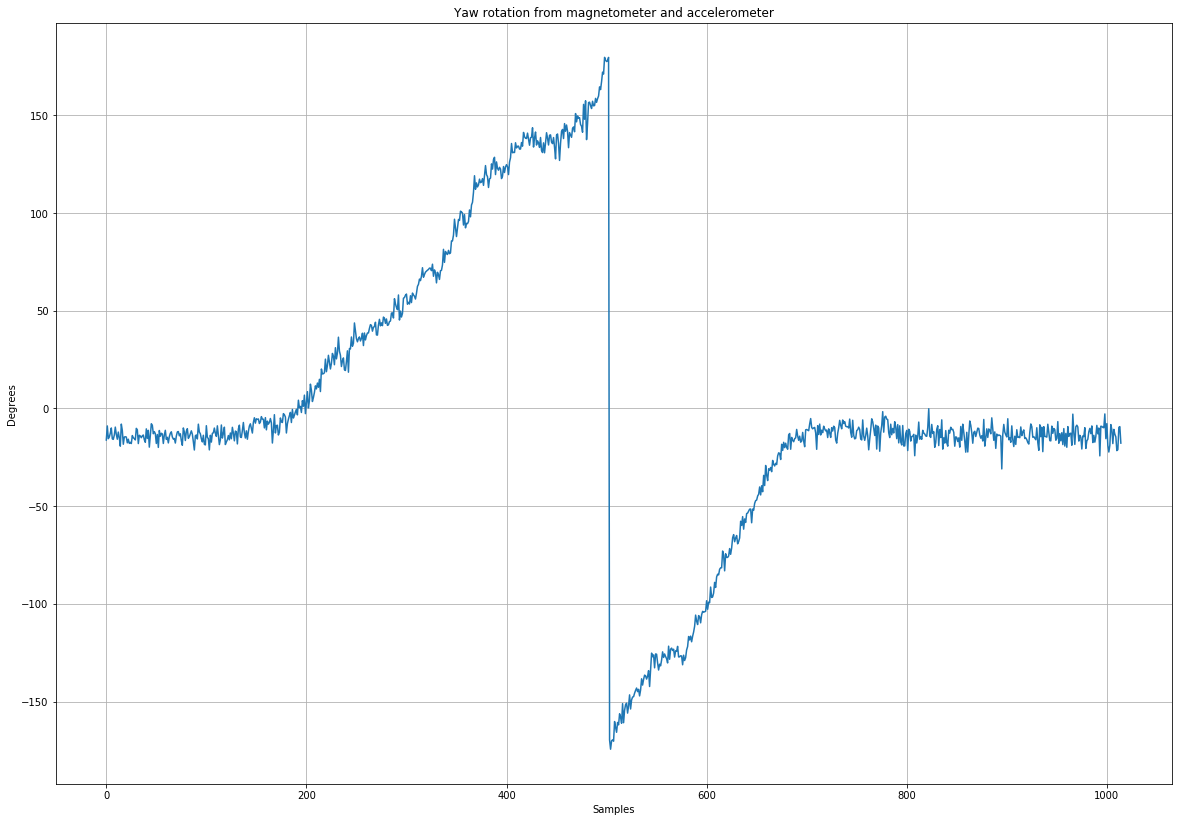

In [20]:
df=load_and_preprocess_file("../data/yaw-360.csv",convert_measurements=True)
process_and_plot_yaw(df)

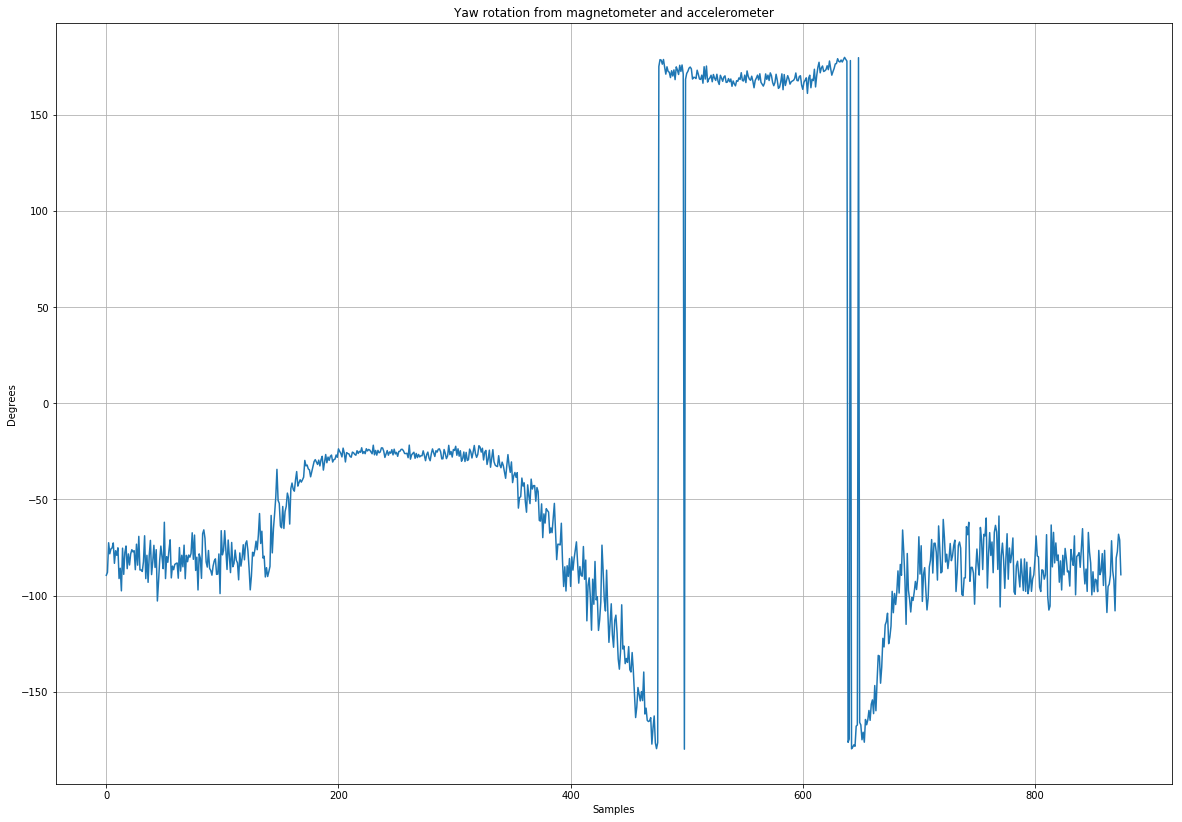

In [21]:
df=load_and_preprocess_file("../data/roll-left-then-right.csv",convert_measurements=True)
process_and_plot_yaw(df)

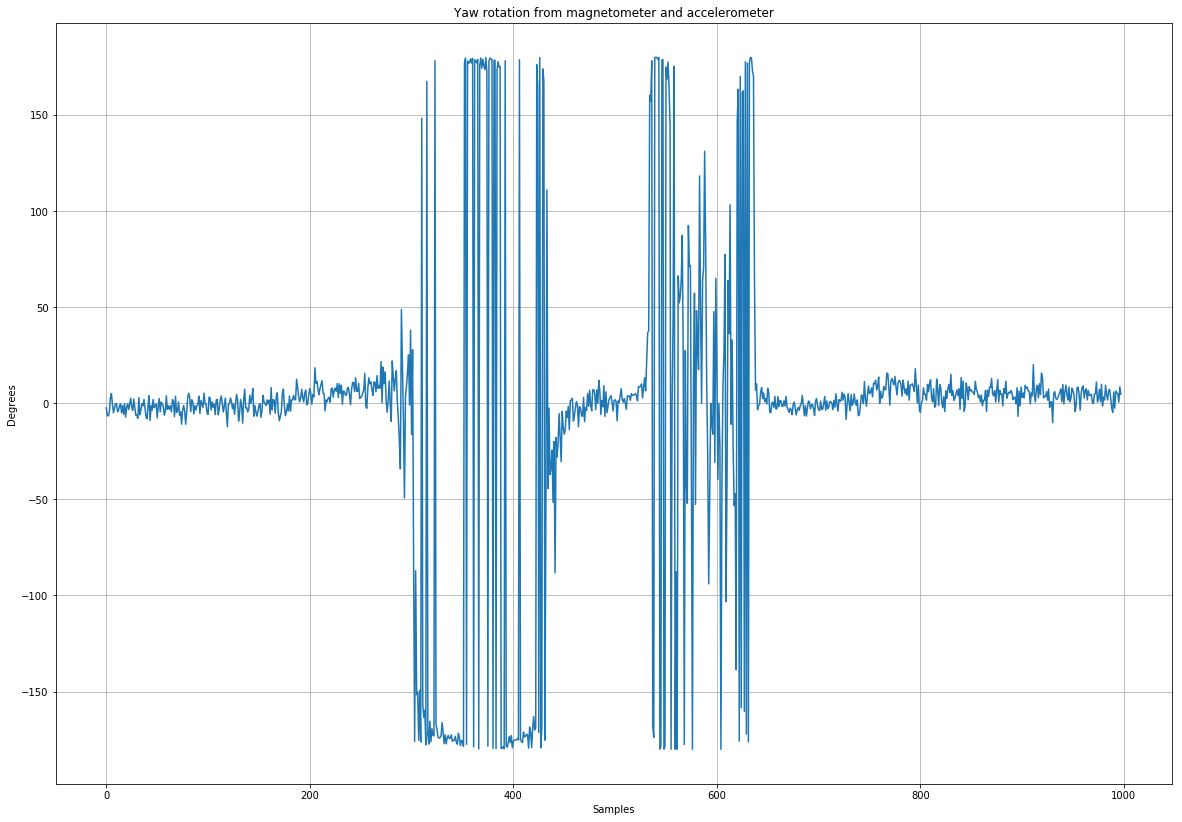

In [22]:
df=load_and_preprocess_file("../data/pitch-up-then-down.csv",convert_measurements=True)
process_and_plot_yaw(df)